In [91]:
import tensorflow as tf
import miscellaneous as mc
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# 取得 model
myModel = mc.get_model()

In [7]:
checkpoint_path = './model_save/mdfk_E10000'
myModel.load_weights(checkpoint_path);

In [10]:
# 來看看 我們的 model 準確率
x, y = mc.get_datas_X_y(tar_pth='./data/segmented',quiet=True)
myModel.evaluate(x,y)

158/158 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9762


[0.0797603651881218, 0.9762375950813293]

In [130]:
# input 輸入
input_img = Image.open('./test_image.jpg')
# 縮小圖片
ff = 4
input_img = input_img.resize(size=(input_img.size[0]//ff,input_img.size[1]//ff))
output = input_img.copy()
# 轉 ndarray
input_img = np.asarray(input_img)
# 開切
params = mc.get_each_subwindows_params(input_img,mask_size=32, stride=5)
sub_images = mc.get_subimage_by_windows_params(input_img, params)

# 拆出來的 sub-image
print(sub_images.shape)
# params['coordi']
print("params len():", len(params['coordi']))

(13689, 32, 32, 3)
params len(): 13689


In [132]:
# 根據 一開始設計的 輸出 意義
"""
 [1 0] ,代表  (Background) 100%
 [0 1] ,代表  (QR Code) 100%
"""
import time
tStart = time.time()#計時開始
pred = myModel.predict(sub_images)
tEnd = time.time()#計時結束
#列印結果
print ("It cost {:.3f} sec".format(tEnd - tStart))#會自動做近位
print (tEnd - tStart)#原型長這樣

It cost 0.268 sec
0.2682826519012451


0.003761023


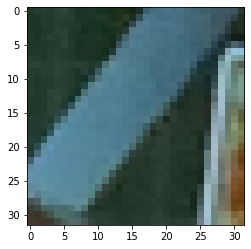

In [133]:
# 預測出來的 爛咚咚
idx = 66
# 轉成小數點
print(pred[idx,1])
plt.imshow(sub_images[idx]);

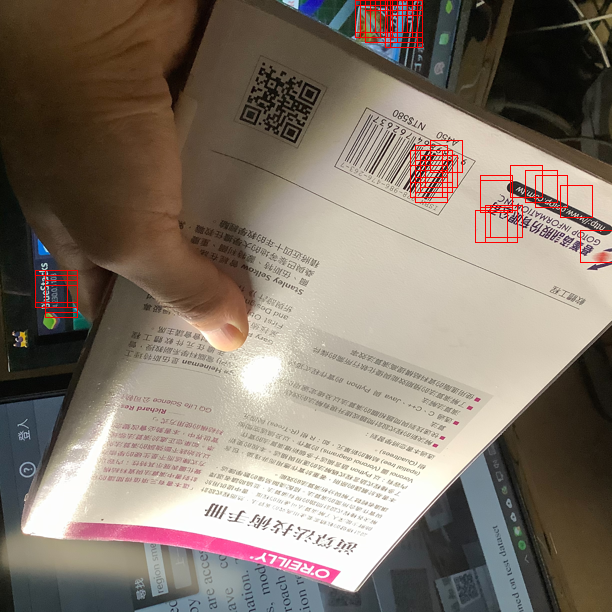

In [134]:
# 將這些爛咚咚 投影到 原始圖片
pred_threshold = 0.3 # 大於此的 project back 回原圖

# 表示 qr code 機率 > 閥值的找出來
qrcode_mask = pred[:,1] > pred_threshold

# 準備 project back 的參數

if len(qrcode_mask) != len(params['coordi']):
    raise Exception("重大錯誤!! 預測出來的 mask 數量 與 sub-region 數量不同..., mask:{},sub:{}"
                    .format(len(qrcode_mask),len(params['coordi'])))

# 取得 是 True 的區域 idx
positive_idx = np.where(qrcode_mask==True)[0]
# 是 positive 的座標
positive_coordi = [params['coordi'][idx] for idx in positive_idx]
# 取得 sub-region 
window_w, windows_h = params['mask_size']

# project back and show
out = output.copy() # 使用副本
out_img = ImageDraw.Draw(out,mode='RGB')

for codi in positive_coordi:
    w, h = window_w, windows_h
    x0, y0 = codi[1],codi[0]
    x1, y1 = x0+w, y0+h
    shape = [x0, y0, x1, y1] 
    out_img.rectangle(xy=shape, outline ="red")
    
out